# Humanitarian Task Image Classification 

In this notebook, we use a pre-trained Inception v3 image classifier to classify tweet images for humanitarian task classification.

In [42]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import csv
import math
import pickle
import stanza
import cv2
import copy
import seaborn as sns
import time
from PIL import Image
from sklearn import metrics

from torch.utils.data.sampler import BatchSampler, RandomSampler, Sampler, \
    SequentialSampler, SubsetRandomSampler
from torch.utils.data import Dataset
from torch.nn import functional
from torch import nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, \
    precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict, OrderedDict, Counter
from json import load, dump
from torchvision import datasets, models, transforms

## 1. Load Datafiles

In [4]:
train_split_df = pd.read_csv('./data/crisis-mmd/task_humanitarian_text_img_train.tsv', sep='\t')

In [5]:
train_split_df.head()

,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_humanitarian,other_relevant_information,not_humanitarian,Negative
1,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,infrastructure_and_utility_damage,Negative
2,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
3,california_wildfires,917793137925459968,917793137925459968_1,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive
4,california_wildfires,917793137925459968,917793137925459968_2,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive


In [6]:
labels = Counter(train_split_df['label'])
labels

Counter({'not_humanitarian': 5260,
         'other_relevant_information': 3294,
         'infrastructure_and_utility_damage': 1905,
         'vehicle_damage': 134,
         'affected_individuals': 424,
         'rescue_volunteering_or_donation_effort': 2323,
         'injured_or_dead_people': 244,
         'missing_or_found_people': 24})

In [7]:
label_map = {
    'affected_individuals': 0,
    'infrastructure_and_utility_damage': 1,
    'not_humanitarian': 2,
    'other_relevant_information': 3,
    'rescue_volunteering_or_donation_effort': 4,
    'vehicle_damage': 1,
    'injured_or_dead_people': 0,
    'missing_or_found_people': 0
}

In [8]:
def image_transform(image):

    h, w, _ = image.shape
    target_len = 299
    padded_image = np.zeros((target_len, target_len, 3)).astype(int)


    if w > h:
        # Resize to [] x 299
        image = cv2.resize(image, (target_len, math.floor(h / (w / target_len))))
        short_len = image.shape[0]

        # Pad to 299 x 299
        padded_image[math.floor((target_len - short_len) / 2):
                     math.floor((target_len - short_len) / 2) + short_len,
                     :, :] = image
    else:
        # Resize to 299 x []
        image = cv2.resize(image, (math.floor(w / (h / target_len)), target_len))
        short_len = image.shape[1]

        # Pad to 299 x 299
        padded_image[:, math.floor((target_len - short_len) / 2):
                     math.floor((target_len - short_len) / 2) + short_len,
                     :] = image
    
    return padded_image

image = cv2.imread('./data/crisis-mmd/{}'.format(train_split_df.iloc[3, 4]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

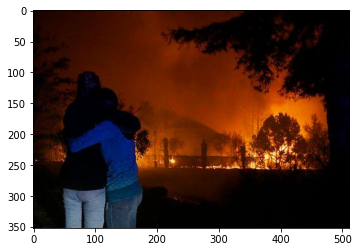

In [84]:
plt.imshow(image)
plt.show()

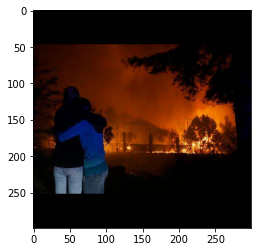

In [85]:
plt.imshow(image_transform(image))
plt.show()

In [9]:
class ImageDataset(Dataset):

    def __init__(self, tsv_file, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.file_df = pd.read_csv(tsv_file, sep='\t')
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.file_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.file_df.iloc[idx, 4])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize one dimension of image to 299
        image = image_transform(image)
        
        # Swap axis
        image = image.transpose((2, 0, 1))
        
        # Normalize the image
        image = image / 255
        image = torch.from_numpy(image)
        image = self.normalize(image).float()
        
        # Get the label
        label = label_map[self.file_df.iloc[idx, 5]]
        
        return image, label

In [10]:
train_dataset = ImageDataset('./data/crisis-mmd/task_humanitarian_text_img_train.tsv',
                             './data/crisis-mmd')

In [11]:
for i in train_dataset:
    print(i[0].shape, i[1])
    break

torch.Size([3, 299, 299]) 2


## 2. Fine-tune Inception v3

In [242]:
num_classes = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [243]:
train_dataset = ImageDataset('./data/crisis-mmd/task_humanitarian_text_img_train.tsv',
                             './data/crisis-mmd')
dev_dataset = ImageDataset('./data/crisis-mmd/task_humanitarian_text_img_dev.tsv',
                             './data/crisis-mmd')
test_dataset = ImageDataset('./data/crisis-mmd/task_humanitarian_text_img_test.tsv',
                             './data/crisis-mmd')

In [244]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4)
dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=4)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [245]:
for inputs, labels in train_dataset_loader:
    print(inputs.shape, labels)
    break

torch.Size([32, 3, 299, 299]) tensor([1, 2, 4, 2, 0, 2, 3, 2, 3, 2, 2, 2, 2, 2, 4, 2, 3, 2, 1, 2, 4, 4, 4, 3,
        3, 3, 4, 4, 2, 2, 4, 2])


In [250]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,
                patience=20, is_inception=True):
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Early stopping
    es_counter = 0
    es = False

    for epoch in range(num_epochs):
        if es:
            break

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    es_counter = 0
                else:
                    es_counter += 1
                    if es_counter > patience:
                        es = True

                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [247]:
model_ft = models.inception_v3(pretrained=True)

for name, param in model_ft.named_parameters():
    
    if name not in set(['fc.weight', 'fc.bias', 'AuxLogits.fc.weight', 'AuxLogits.fc.bias']):
        param.requires_grad = False
    else:
        param.requires_grad = True

In [296]:
# Handle the auxilary net
num_ftrs = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

# Handle the primary net
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,num_classes)

model_ft = model_ft.to(device)

params_to_update = [p for p in model_ft.parameters() if p.requires_grad]

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-6, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

In [295]:
# dataloaders = {'train': train_dataset_loader,
#                'val': dev_dataset_loader}

# model, val_acc_history = train_model(model_ft, dataloaders, criterion,
#                                      optimizer_ft, num_epochs=500,
#                                      patience=50, is_inception=True)

# torch.save(model.state_dict(), './output/best_weights.pk')
# dump(val_acc_history, open('./output/val_acc_history.json', 'w'))

## VGG-16

In [12]:
class ImageDataset(Dataset):

    def __init__(self, tsv_file, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.file_df = pd.read_csv(tsv_file, sep='\t')
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.file_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.file_df.iloc[idx, 4])
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = label_map[self.file_df.iloc[idx, 5]]
        
        return image, label

In [13]:
num_classes = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDataset('./data/crisis-mmd/task_humanitarian_text_img_train.tsv',
                             './data/crisis-mmd')
dev_dataset = ImageDataset('./data/crisis-mmd/task_humanitarian_text_img_dev.tsv',
                             './data/crisis-mmd')
test_dataset = ImageDataset('./data/crisis-mmd/task_humanitarian_text_img_test.tsv',
                             './data/crisis-mmd')

In [14]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4)
dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=4)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [290]:
for inputs, labels in train_dataset_loader:
    print(inputs.shape, torch.max(inputs), labels)
    break

torch.Size([32, 3, 224, 224]) tensor(2.6400) tensor([2, 2, 2, 3, 4, 3, 2, 0, 2, 0, 1, 3, 1, 3, 1, 1, 1, 4, 2, 2, 2, 2, 4, 2,
        2, 1, 4, 3, 4, 2, 4, 2])


In [291]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, patience=20):
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Early stopping
    es_counter = 0
    es = False

    for epoch in range(num_epochs):
        if es:
            break

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    es_counter = 0
                else:
                    es_counter += 1
                    if es_counter > patience:
                        es = True

                val_acc_history.append(epoch_acc)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [44]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model = model.to(device)

params_to_update = [p for p in model.parameters() if p.requires_grad]

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [294]:
dataloaders = {'train': train_dataset_loader,
               'val': dev_dataset_loader}

model, val_acc_history = train_model(model, dataloaders, criterion,
                                     optimizer_ft, num_epochs=200,
                                     patience=30)

torch.save(model.state_dict(), './output/best_weights.pk')
# dump(val_acc_history, open('./output/val_acc_history.json', 'w'))

train:   0%|          | 0/426 [00:00<?, ?it/s]

Epoch 0/199
----------


train:   2%|▏         | 9/426 [00:02<01:37,  4.29it/s]


KeyboardInterrupt: 

## 3. Analysis

In [15]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights.pk'))
model = model.to(device)

In [305]:
batch_size = 32

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [311]:
predictions = []
true_labels = []

for inputs, labels in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    
    predictions.extend(preds.cpu().numpy().tolist())
    true_labels.extend(labels.cpu().numpy().tolist())


100%|██████████| 70/70 [00:08<00:00,  8.00it/s]


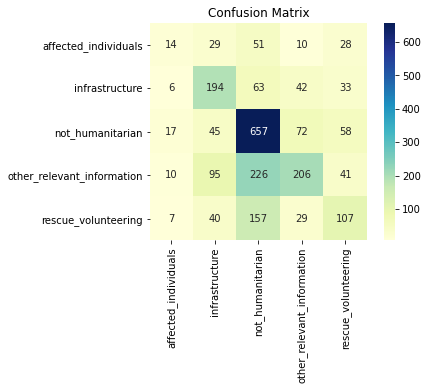

In [322]:
import seaborn as sns;

confusion = metrics.confusion_matrix(true_labels, predictions)


ticks = ['affected_individuals', 'infrastructure',
         'not_humanitarian', 'other_relevant_information',
         'rescue_volunteering']

plt.title('Confusion Matrix')
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", square=True,
                 xticklabels=ticks, yticklabels=ticks)

In [326]:
print(len(train_dataset), len(dev_dataset), len(test_dataset))

13608 2237 2237


In [328]:
metrics.accuracy_score(true_labels, predictions)

0.5265981224854717

In [331]:
metrics.f1_score(true_labels, predictions, average='macro')

0.42448501211138556

In [333]:
metrics.precision_score(true_labels, predictions, average='macro')

0.4569076294407236

In [335]:
metrics.recall_score(true_labels, predictions, average='macro')

0.4249967919288039

## Extract Last Layer Feature

In [349]:
model.classifier._modules['6'][0]
model.classifier._modules['3']

Linear(in_features=4096, out_features=4096, bias=True)

In [372]:
class ImageDatasetExtract(Dataset):

    def __init__(self, tsv_file, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.file_df = pd.read_csv(tsv_file, sep='\t')
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.file_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.file_df.iloc[idx, 4])
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = label_map[self.file_df.iloc[idx, 5]]
        
        tid = self.file_df.iloc[idx, 1]
        
        return image, label, tid

In [373]:
num_classes = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDatasetExtract('./data/crisis-mmd/task_humanitarian_text_img_train.tsv',
                             './data/crisis-mmd')
dev_dataset = ImageDatasetExtract('./data/crisis-mmd/task_humanitarian_text_img_dev.tsv',
                             './data/crisis-mmd')
test_dataset = ImageDatasetExtract('./data/crisis-mmd/task_humanitarian_text_img_test.tsv',
                             './data/crisis-mmd')

In [374]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [399]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights.pk'))
model = model.to(device)

In [400]:
output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

In [401]:
for inputs, labels, tids in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    output_256_tid.extend(tids.detach().cpu().numpy().tolist())

    outputs = model(inputs)

100%|██████████| 70/70 [00:08<00:00,  7.94it/s]


In [404]:
np.savez_compressed('./data/image_embedding_256_test.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [405]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights.pk'))
model = model.to(device)

output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

for inputs, labels, tids in tqdm(dev_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    output_256_tid.extend(tids.detach().cpu().numpy().tolist())

    outputs = model(inputs)

 76%|███████▌  | 53/70 [00:06<00:02,  8.47it/s]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 70/70 [00:08<00:00,  7.89it/s]


In [406]:
print(len(output_256_tid), len(output_256))

2237 2237


In [407]:
np.savez_compressed('./data/image_embedding_256_dev.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [409]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights.pk'))
model = model.to(device)

output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

for inputs, labels, tids in tqdm(train_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    output_256_tid.extend(tids.detach().cpu().numpy().tolist())

    outputs = model(inputs)

 81%|████████  | 344/426 [00:42<00:09,  8.85it/s]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 426/426 [00:51<00:00,  8.19it/s]


In [410]:
print(len(output_256_tid), len(output_256))

13608 13608


In [411]:
np.savez_compressed('./data/image_embedding_256_train.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [412]:
tt = np.load('./data/image_embedding_256_test.npz')

In [414]:
tt['image_embedding'].shape

(2237, 256)

In [415]:
tt['image_tweetID'].shape

(2237,)

## Extract Classification Probabilities

In [16]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights.pk'))
model = model.to(device)

In [35]:
class ImageDatasetExtract(Dataset):

    def __init__(self, tsv_file, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.file_df = pd.read_csv(tsv_file, sep='\t')
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.file_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.file_df.iloc[idx, 4])
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = label_map[self.file_df.iloc[idx, 5]]
        
        tid = self.file_df.iloc[idx, 1]
        
        return image, label, tid

In [36]:
num_classes = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDatasetExtract('./data/crisis-mmd/task_humanitarian_text_img_train.tsv',
                             './data/crisis-mmd')
dev_dataset = ImageDatasetExtract('./data/crisis-mmd/task_humanitarian_text_img_dev.tsv',
                             './data/crisis-mmd')
test_dataset = ImageDatasetExtract('./data/crisis-mmd/task_humanitarian_text_img_test.tsv',
                             './data/crisis-mmd')

In [37]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [40]:
# Test set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(tids.detach().cpu().numpy().tolist())

test_probs = np.vstack(test_probs)

100%|██████████| 70/70 [00:08<00:00,  8.27it/s]


In [44]:
np.savez_compressed('./data/image_predict_probs_test.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

In [49]:
# Training set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(train_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(tids.detach().cpu().numpy().tolist())

test_probs = np.vstack(test_probs)

np.savez_compressed('./data/image_predict_probs_train.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

 83%|████████▎ | 354/426 [00:42<00:09,  7.31it/s]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 426/426 [00:51<00:00,  8.33it/s]


In [50]:
# Developing set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(dev_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(tids.detach().cpu().numpy().tolist())

test_probs = np.vstack(test_probs)

np.savez_compressed('./data/image_predict_probs_dev.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

 13%|█▎        | 9/70 [00:01<00:16,  3.63it/s]/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 70/70 [00:08<00:00,  8.37it/s]


In [47]:
len(test_probs_tids)

13608

In [54]:
data = np.load('./data/image_predict_probs_test.npz')
print(data['predict_probs'].shape)
print(data['image_tweetID'].shape)

(2237, 5)
(2237,)


## MMHS150K Dataset

### 1. Train the Model

In [62]:
from json import load, dump

In [63]:
labels = load(open('./MMHS150K_GT.json', 'r'))

In [64]:
binary_labels = {}

for k in labels:
    binary_labels[k] = int(labels[k]['labels'].count(0) <= 1)

In [65]:
splits = {}

for name in ['train', 'val', 'test']:
    with open('./splits/{}_ids.txt'.format(name)) as fp:
        lines = [l.replace('\n', '') for l in fp.readlines()]
        splits[name] = lines

In [69]:
Counter([binary_labels[k] for k in binary_labels])

Counter({1: 36978, 0: 112845})

In [70]:
sub_labels = {'train': [], 'val': [], 'test': []}

for n in ['train', 'val', 'test']:
    for l in splits[n]:
        sub_labels[n].append(binary_labels[l])

(array([105346.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  29477.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

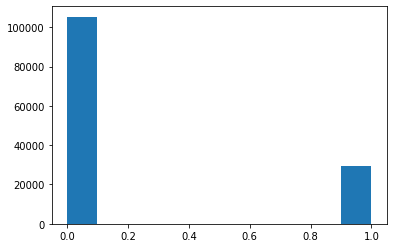

In [79]:
plt.hist(sub_labels['train'])

In [13]:
def image_transform(image):

    h, w, _ = image.shape
    target_len = 299
    padded_image = np.zeros((target_len, target_len, 3)).astype(int)


    if w > h:
        # Resize to [] x 299
        image = cv2.resize(image, (target_len, math.floor(h / (w / target_len))))
        short_len = image.shape[0]

        # Pad to 299 x 299
        padded_image[math.floor((target_len - short_len) / 2):
                     math.floor((target_len - short_len) / 2) + short_len,
                     :, :] = image
    else:
        # Resize to 299 x []
        image = cv2.resize(image, (math.floor(w / (h / target_len)), target_len))
        short_len = image.shape[1]

        # Pad to 299 x 299
        padded_image[:, math.floor((target_len - short_len) / 2):
                     math.floor((target_len - short_len) / 2) + short_len,
                     :] = image
    
    return padded_image

image = cv2.imread('./mmhs150k-img/{}.jpg'.format('1114679353714016256'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

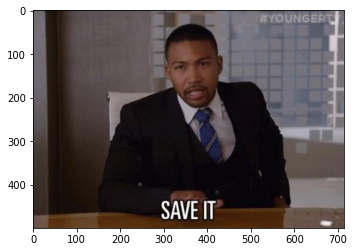

In [14]:
plt.imshow(image)
plt.show()

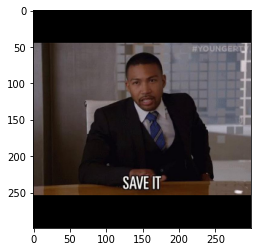

In [15]:
plt.imshow(image_transform(image))
plt.show()

In [16]:
class ImageDataset(Dataset):

    def __init__(self, ids, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.ids = ids
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, '{}.jpg'.format(self.ids[idx]))
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = binary_labels[self.ids[idx]]
        
        return image, label

In [17]:
train_dataset = ImageDataset(splits['train'], './mmhs150k-img')

In [18]:
for i in train_dataset:
    print(i[0].shape, i[1])
    break

torch.Size([3, 224, 224]) 1


In [19]:
num_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDataset(splits['train'], './mmhs150k-img')
dev_dataset = ImageDataset(splits['val'], './mmhs150k-img')
test_dataset = ImageDataset(splits['test'], './mmhs150k-img')

In [20]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=4)
dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 num_workers=4)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [21]:
for inputs, labels in train_dataset_loader:
    print(inputs.shape, torch.max(inputs), labels)
    break

torch.Size([32, 3, 224, 224]) tensor(2.6400) tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0])


In [23]:
torch.Tensor([1,2])

tensor([1., 2.])

In [39]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, patience=20):
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1 = 0
    
    # Early stopping
    es_counter = 0
    es = False

    for epoch in range(num_epochs):
        if es:
            break

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            running_predicts = []
            running_labels = []

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                running_predicts.extend(preds.tolist())
                running_labels.extend(labels.data.tolist())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                # Compute F1 score
                y_true = torch.Tensor(running_labels)
                y_pred = torch.Tensor(running_predicts)
                tp = (y_true * y_pred).sum().to(torch.float32)
                tn = ((1 - y_true) * (1 - y_pred)).sum().to(torch.float32)
                fp = ((1 - y_true) * y_pred).sum().to(torch.float32)
                fn = (y_true * (1 - y_pred)).sum().to(torch.float32)

                epsilon = 1e-7

                precision = tp / (tp + fp + epsilon)
                recall = tp / (tp + fn + epsilon)

                f1 = 2 * (precision*recall) / (precision + recall + epsilon)
                
                print(f1)
    
                if f1 > best_f1:
                    best_f1 = f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    es_counter = 0
                else:
                    es_counter += 1
                    if es_counter > patience:
                        es = True

                val_acc_history.append(epoch_acc)

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [40]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model = model.to(device)

params_to_update = [p for p in model.parameters() if p.requires_grad]

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)
criterion = nn.CrossEntropyLoss()

In [43]:
# dataloaders = {'train': train_dataset_loader,
#                'val': dev_dataset_loader}

# model, val_acc_history = train_model(model, dataloaders, criterion,
#                                      optimizer_ft, num_epochs=200,
#                                      patience=30)

# #torch.save(model.state_dict(), './output/best_weights_mmhs150k.pk')
# # dump(val_acc_history, open('./output/val_acc_history.json', 'w'))

## 3. Analysis

In [44]:
num_classes = 2
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_mmhs150k.pk'))
model = model.to(device)

In [54]:
batch_size = 32

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [55]:
predictions = []
true_labels = []
criterion = nn.CrossEntropyLoss()

for inputs, labels in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)


    outputs = model(inputs)

    _, preds = torch.max(outputs, 1)
    
    predictions.extend(preds.cpu().numpy().tolist())
    true_labels.extend(labels.cpu().numpy().tolist())


100%|██████████| 313/313 [00:23<00:00, 13.16it/s]


In [47]:
confusion = metrics.confusion_matrix(true_labels, predictions)

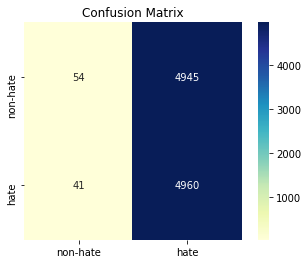

In [48]:
import seaborn as sns;

ticks = ['non-hate', 'hate']

plt.title('Confusion Matrix')
ax = sns.heatmap(confusion, annot=True, fmt="d", cmap="YlGnBu", square=True,
                 xticklabels=ticks, yticklabels=ticks)

In [56]:
Counter(predictions)

Counter({1: 9907, 0: 93})

In [57]:
print(len(train_dataset), len(dev_dataset), len(test_dataset))

134823 5000 10000


In [58]:
metrics.accuracy_score(true_labels, predictions)

0.5008

In [59]:
metrics.f1_score(true_labels, predictions)

0.6651462302119667

In [60]:
metrics.precision_score(true_labels, predictions)

0.5004542242858585

In [61]:
metrics.recall_score(true_labels, predictions)

0.9914017196560688

## Extract Last Layer Feature

In [35]:
model.classifier._modules['6'][0]
model.classifier._modules['3']

Linear(in_features=4096, out_features=4096, bias=True)

In [52]:
class ImageDatasetExtract(Dataset):

    def __init__(self, ids, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.ids = ids
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = img_name = os.path.join(self.root_dir, '{}.jpg'.format(self.ids[idx]))
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = binary_labels[self.ids[idx]]
        
        tid = self.ids[idx]
        
        return image, label, tid

In [53]:
num_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDatasetExtract(splits['train'], 'mmhs150k-img')
dev_dataset = ImageDatasetExtract(splits['val'], 'mmhs150k-img')
test_dataset = ImageDatasetExtract(splits['test'], 'mmhs150k-img')

In [54]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [49]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_mmhs150k.pk'))
model = model.to(device)

In [50]:
output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

In [60]:
for inputs, labels, tids in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    output_256_tid.extend(list(tids))

    outputs = model(inputs)

100%|██████████| 313/313 [00:23<00:00, 13.37it/s]


In [67]:
np.savez_compressed('./data/mmhs150k_image_embedding_256_test.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [68]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_mmhs150k.pk'))
model = model.to(device)

output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

for inputs, labels, tids in tqdm(dev_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    output_256_tid.extend(list(tids))

    outputs = model(inputs)

100%|██████████| 157/157 [00:11<00:00, 13.16it/s]


In [69]:
print(len(output_256_tid), len(output_256))

5000 5000


In [70]:
np.savez_compressed('./data/mmhs150k_image_embedding_256_dev.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [71]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_mmhs150k.pk'))
model = model.to(device)

output_256 = []
output_256_tid = []

def get_output(self, input, output):
    cur_output = output.data.detach().cpu().numpy()
    for i in range(cur_output.shape[0]):
        output_256.append(cur_output[i, :])

model.classifier._modules['6'][0].register_forward_hook(get_output)

for inputs, labels, tids in tqdm(train_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    output_256_tid.extend(list(tids))

    outputs = model(inputs)

 22%|██▏       | 945/4214 [01:10<03:58, 13.71it/s]Traceback (most recent call last):
  File "/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/nethome/zwang3049/jay/miniconda3/envs/nlp/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
100%|██████████| 4214/4214 [05:11<00:00, 13.55it/s]


In [72]:
print(len(output_256_tid), len(output_256))

134823 134823


In [73]:
np.savez_compressed('./data/mmhs150k_image_embedding_256_train.npz',
                    image_embedding=output_256,
                    image_tweetID=output_256_tid)

In [85]:
tt = np.load('./data/mmhs150k_image_embedding_256_test.npz')

In [86]:
print(tt['image_embedding'].shape)
print(tt['image_tweetID'].shape)

(10000, 256)
(10000,)


## Extract Classification Probabilities

In [74]:
model = models.vgg16(pretrained=True)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False
    
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, num_classes))

model.load_state_dict(torch.load('./output/best_weights_mmhs150k.pk'))
model = model.to(device)

In [35]:
class ImageDatasetExtract(Dataset):

    def __init__(self, ids, root_dir):
        """
        Args:
            tsv_file (string): Path to the train/test/dev split tsv file
            root_dir (string): Directory with all the images.
        """
        self.ids = ids
        self.root_dir = root_dir
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.resize = transforms.Resize(256)
        self.center = transforms.CenterCrop(224)
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = img_name = os.path.join(self.root_dir, '{}.jpg'.format(self.ids[idx]))
        image = Image.open(img_name).convert('RGB')
        
        image = self.resize(image)
        image = self.center(image)
        
        image = self.to_tensor(image)
        image = self.normalize(image)
        
        # Get the label
        label = binary_labels[self.ids[idx]]
        
        tid = self.ids[idx]
        
        return image, label, tid

In [75]:
num_classes = 2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = ImageDatasetExtract(splits['train'], 'mmhs150k-img')
dev_dataset = ImageDatasetExtract(splits['val'], 'mmhs150k-img')
test_dataset = ImageDatasetExtract(splits['test'], 'mmhs150k-img')

In [76]:
batch_size = 32

train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  num_workers=4)

In [77]:
# Test set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(test_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(list(tids))

test_probs = np.vstack(test_probs)

100%|██████████| 313/313 [00:23<00:00, 13.50it/s]


In [80]:
np.savez_compressed('./data/mmhs150k_image_predict_probs_test.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

In [81]:
# Training set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(train_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(list(tids))

test_probs = np.vstack(test_probs)

np.savez_compressed('./data/mmhs150k_image_predict_probs_train.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

100%|██████████| 4214/4214 [05:07<00:00, 13.69it/s]


In [82]:
# Developing set

test_probs = []
test_probs_tids = []

for inputs, labels, tids in tqdm(dev_dataset_loader):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    softmax_outputs = nn.functional.softmax(outputs, dim=1).detach().cpu().numpy()
    test_probs.append(softmax_outputs)
    
    test_probs_tids.extend(list(tids))

test_probs = np.vstack(test_probs)

np.savez_compressed('./data/mmhs150k_image_predict_probs_dev.npz',
                    predict_probs=test_probs,
                    image_tweetID=test_probs_tids)

100%|██████████| 157/157 [00:11<00:00, 13.32it/s]


In [47]:
len(test_probs_tids)

13608

In [83]:
data = np.load('./data/mmhs150k_image_predict_probs_test.npz')
print(data['predict_probs'].shape)
print(data['image_tweetID'].shape)

(10000, 2)
(10000,)


## Fake Image Dataset

In [48]:
import urllib.request

# urllib.request.urlretrieve("http://www.digimouth.com/news/media/2011/09/google-logo.jpg", "local-filename.jpg")

In [53]:
img_df = pd.read_csv('./verification/set_images.txt', sep='\t')

In [54]:
img_df.head()

,image_id,image_url,annotation,event
0,boston_fake_01,http://i.imgur.com/LvoCC5T.jpg,fake,boston
1,boston_fake_02,http://instagram.com/p/YN7_ThPXrU/,fake,boston
2,boston_fake_03,https://o.twimg.com/2/proxy.jpg?t=HBgeaHR0cDov...,fake,boston
3,boston_fake_04,http://media.tumblr.com/a813460e72a178d8127b50...,fake,boston
4,boston_fake_05,http://i.imgur.com/uxAh4wwh.jpg,fake,boston


In [55]:
img_df['image_url']

0                         http://i.imgur.com/LvoCC5T.jpg
1                     http://instagram.com/p/YN7_ThPXrU/
2      https://o.twimg.com/2/proxy.jpg?t=HBgeaHR0cDov...
3      http://media.tumblr.com/a813460e72a178d8127b50...
4                        http://i.imgur.com/uxAh4wwh.jpg
                             ...                        
394      https://pbs.twimg.com/media/Bic4fA5CQAAT5KY.jpg
395      https://pbs.twimg.com/media/BialJuECIAATXE2.jpg
396      https://pbs.twimg.com/media/BiVisqpCIAAbgju.jpg
397      https://pbs.twimg.com/media/Bo-CY5ACcAAiRAw.jpg
398      https://pbs.twimg.com/media/BpJguJhIMAAQsZK.jpg
Name: image_url, Length: 399, dtype: object

In [56]:
img_df.shape

(399, 4)

In [ ]:
for i, row in img_df.iterrows():
    try:
        urllib.request.urlretrieve(row['image_url'], './verification/imgs/{}.jpg'.format(row['image_id']))
    except:
        pass